In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
import cv2 as cv
import scipy.ndimage
import skimage as skimage

%config InlineBackend.figure_format ='retina'
plt.rcParams.update({'font.size': 15})
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys

# Don't generate the __pycache__ folder locally
sys.dont_write_bytecode = True 

# Print exception without the buit-in python warning
sys.tracebacklimit = 0 

In [2]:
from modules import *

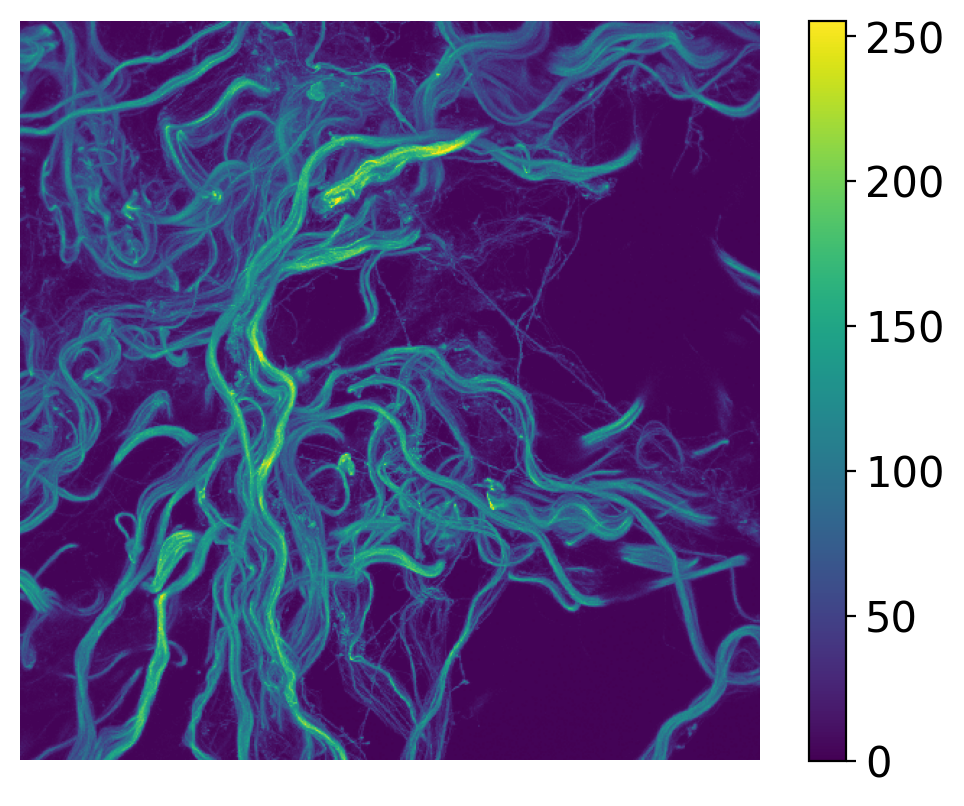

In [3]:
raw_image = convert_to_8bit_grayscale('TestImage1.tif')

plt.imshow(raw_image)

plt.axis('off')
plt.colorbar()
plt.show()

In [4]:
image_filter_sigma = 1
local_sigma = 10
threshold_value = max(int(0.5 * np.median(raw_image)), 2)

spacing = 20 # Spacing between plotting the orientation vectors
scale = 60 # Length of each vector for plotting

In [5]:
filtered_image = skimage.filters.gaussian(raw_image, 
                                          sigma = image_filter_sigma, 
                                          mode = 'nearest', 
                                          preserve_range = True)

In [6]:
image_gradient_x, image_gradient_y = make_image_gradients(filtered_image)

In [7]:
Structure_Tensor, EigenValues, EigenVectors, Jxx, Jxy, Jyy = make_structure_tensor_2d(image_gradient_x, 
                                                                                      image_gradient_y, 
                                                                                      local_sigma)

In [8]:
Image_Coherance = make_coherence(filtered_image, 
                                 EigenValues, 
                                 Structure_Tensor,
                                 threshold_value)

In [9]:
Image_Orientation = make_orientation(filtered_image, 
                                     Jxx, Jxy, Jyy, 
                                     threshold_value)

In [10]:
vx, vy = make_vxvy(filtered_image, EigenVectors, threshold_value)

In [12]:
fig, ax = plt.subplots(1, 4, figsize = (45, 15), sharex = True, sharey = True)

ax[0].imshow(raw_image,cmap = 'viridis')

ax[0].set_title('Image', pad = 20, fontsize = 40)
ax[0].set_xticks([])
ax[0].set_yticks([])

divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes("right", size="5%", pad=0.4)
cax0.remove()

########################################################################

# im1 = ax[1].imshow(Image_Coherance, vmin = 0, vmax = 1, cmap = 'Spectral_r')
im1 = ax[1].imshow(plt.cm.gray(raw_image/raw_image.max()) * plt.cm.Spectral_r(Image_Coherance), 
            vmin = 0, vmax = 1, cmap = 'Spectral_r')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad = 0.4)
cbar = fig.colorbar(im1, cax = cax, ticks = np.linspace(0, 1, 5))
cbar.ax.set_yticklabels([r'$0$', r'$0.25$', r'$0.5$', r'$0.75$', r'$1$'], fontsize = 40)

ax[1].set_title('Coherance', pad = 20, fontsize = 40)
ax[1].set_xticks([])
ax[1].set_yticks([])

###########################################################data#############

# im2 = ax[2].imshow(Image_Orientation/180, vmin = 0, vmax = 1, cmap = 'hsv')
im2 = ax[2].imshow(plt.cm.gray(raw_image/raw_image.max()) * plt.cm.hsv(Image_Orientation/180), 
           vmin = 0, vmax = 1, cmap = 'hsv')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.4)
cbar = fig.colorbar(im2, cax = cax, ticks = np.linspace(0, 1, 5))
cbar.ax.set_yticklabels([r'$0^{\circ}$', r'$45^{\circ}$', r'$90^{\circ}$', r'$135^{\circ}$', r'$180^{\circ}$'], 
                        fontsize = 40)

ax[2].set_title('Orientation', pad = 20, fontsize = 40)
ax[2].set_xticks([])
ax[2].set_yticks([])

########################################################################

im3 = ax[3].imshow(raw_image, cmap = 'Oranges', alpha = 0.7)

xmesh, ymesh = np.meshgrid(np.arange(raw_image.shape[0]), 
                           np.arange(raw_image.shape[1]), 
                           indexing = 'ij')

ax[3].quiver(ymesh[spacing//2::spacing, spacing//2::spacing], 
             xmesh[spacing//2::spacing, spacing//2::spacing],
             vy[spacing//2::spacing, spacing//2::spacing], 
             vx[spacing//2::spacing, spacing//2::spacing],
             scale = scale, headlength = 0, headaxislength = 0, 
             pivot = 'middle', color = 'k', angles = 'xy')

ax[3].set_title('Orientation Vector Field', pad = 20, fontsize = 40)
ax[3].set_xticks([])
ax[3].set_yticks([])

divider = make_axes_locatable(ax[3])
cax = divider.append_axes("right", size="5%", pad=0.4)
cax.remove()

########################################################################

fig.tight_layout()

plt.savefig('Results.pdf')
plt.close()